In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import albumentations as alb
data_path = "200birds/CUB_200_2011/images"
data_dir = pathlib.Path(data_path)

2024-05-04 09:16:22.421374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 09:16:22.665453: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 09:16:22.698866: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supporte

In [2]:
from tensorflow.keras.models import load_model
model = load_model("encoder_gaussian.h5")

2024-05-04 09:16:26.515456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 09:16:27.513235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22277 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [3]:
train_transform = alb.Compose([
    alb.HorizontalFlip(p=0.5),
    alb.Rotate(always_apply=False, limit=20, p=0.5),
    # alb.RandomCrop(height=224,width=224,p=0.5,always_apply=False),  # 자르기 크기를 적절하게 설정해야 함
    # alb.CoarseDropout(always_apply=False, max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.5),
    # alb.RandomSunFlare(always_apply=False, src_radius=100,flare_roi=(0,0,1,0.2),num_flare_circles_lower=1 ,num_flare_circles_upper=3),
    # alb.ShiftScaleRotate(shift_limit=(-0.02, 0.02),always_apply=False, p=0.5),
    # alb.GaussianBlur(always_apply=False, p=0.5),
    # alb.ZoomBlur(p=0.5)
])

In [4]:
def preprocessing(img, p=0.5):
    img = train_transform(image=img, p=0.5)["image"]
    if np.random.rand() < p:
        img = tf.image.resize(img, (224,224))
        img = model(img[None])
        img = img[0].numpy()
    return img

In [5]:
def parse_tfrecord(tfrecord):
    features = {'image/label': tf.io.FixedLenFeature([], tf.int64),
                'image/encoded': tf.io.FixedLenFeature([], tf.string)}
    sample = tf.io.parse_single_example(tfrecord, features)
    x = tf.image.decode_jpeg(sample['image/encoded'], channels=3)

    y = tf.cast(sample['image/label'], tf.int32)
    y = tf.one_hot(y, 200)
    x = tf.image.resize(x, (224, 224))
    x /=255.
    return x, y

def augmentation(x, y):
    x = tf.numpy_function(func=preprocessing, inp=[x], Tout=[tf.float32])
    return x[0], y

dataset = tf.data.TFRecordDataset('200birds_train.tfrecord').map(
        parse_tfrecord,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
        ).map(augmentation, num_parallel_calls=tf.data.AUTOTUNE
        ).batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

data = dataset.as_numpy_iterator()

In [6]:
cmpset = tf.data.TFRecordDataset('200birds_train.tfrecord').map(
        parse_tfrecord,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
        ).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
cmpdata = cmpset.as_numpy_iterator()

2024-05-04 09:16:30.180026: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


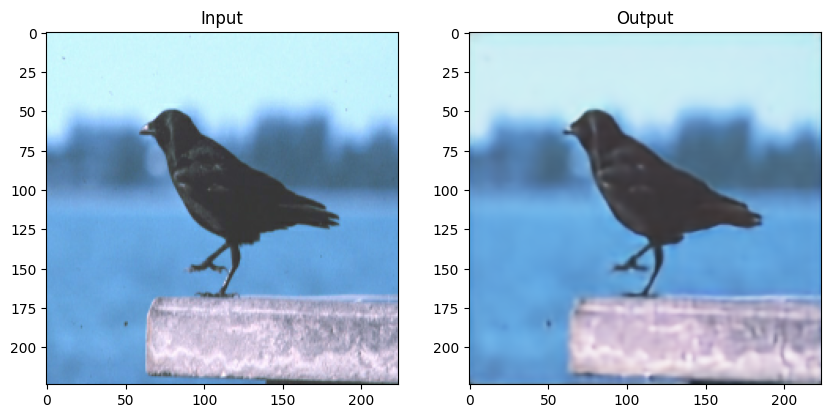

In [7]:
x, y = next(cmpdata)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Input")
plt.imshow(x[0])

plt.subplot(1,2,2)
plt.title("Output")
x = model(x)
plt.imshow(x[0])


In [8]:
def valid_parse_tfrecord(tfrecord):
    features = {'image/label': tf.io.FixedLenFeature([], tf.int64),
                'image/encoded': tf.io.FixedLenFeature([], tf.string)}
    sample = tf.io.parse_single_example(tfrecord, features)
    x = tf.image.decode_jpeg(sample['image/encoded'], channels=3)

    y = tf.cast(sample['image/label'], tf.int32)
    y = tf.one_hot(y, 200)
    x = tf.image.resize(x, (224, 224))
    x /=255.
    return x, y
valid_dataset = tf.data.TFRecordDataset('200birds_valid.tfrecord').map(
        valid_parse_tfrecord,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

data = valid_dataset.take(1).get_single_element()

In [9]:
bird_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3), classes=200, weights='imagenet', include_top=False, classifier_activation='softmax')
x = tf.keras.layers.GlobalAveragePooling2D()(bird_model.output)
x = tf.keras.layers.Dense(200, activation='softmax')(x)

bird_model = tf.keras.Model(inputs=bird_model.input, outputs=x)

In [10]:
initial_lr = 0.001
decay_rate = 0.95
steps = 333
epochs = 15
decay_steps = (steps * epochs) * 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps, decay_rate
)

bird_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
              optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              metrics = ['accuracy'])

In [11]:
history = bird_model.fit(
    dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    # callbacks=[
    #     wandb.keras.WandbCallback(
    #         monitor="val_accuracy",
    #         mode="max",
    #         save_model=False
        )
    # ])
# wandb.finish()

Epoch 1/15


2024-05-03 01:41:54.648577: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


167/167 [==============================] - 469s 3s/step - loss: 3.6843 - accuracy: 0.2398 - val_loss: 3.4742 - val_accuracy: 0.2774
Epoch 2/15
167/167 [==============================] - 451s 3s/step - loss: 2.3041 - accuracy: 0.5701 - val_loss: 3.0793 - val_accuracy: 0.3521
Epoch 3/15
167/167 [==============================] - 456s 3s/step - loss: 1.8427 - accuracy: 0.7166 - val_loss: 2.6194 - val_accuracy: 0.4969
Epoch 4/15
167/167 [==============================] - 452s 3s/step - loss: 1.5721 - accuracy: 0.8071 - val_loss: 2.4008 - val_accuracy: 0.5865
Epoch 5/15
167/167 [==============================] - 452s 3s/step - loss: 1.4075 - accuracy: 0.8664 - val_loss: 2.3018 - val_accuracy: 0.5970
Epoch 6/15
167/167 [==============================] - 456s 3s/step - loss: 1.2860 - accuracy: 0.9092 - val_loss: 2.2950 - val_accuracy: 0.5970
Epoch 7/15
167/167 [==============================] - 445s 3s/step - loss: 1.1888 - accuracy: 0.9393 - val_loss: 2.2760 - val_accuracy: 0.6119
Epoch 8/15

In [12]:
bird_model.save("bird_encoder_0.7375.h5")

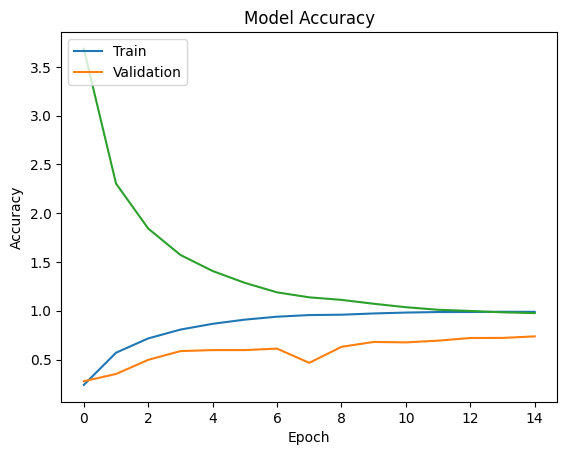

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()